In [2]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../plotting.mplstyle')

In [3]:
import cymetric as cym
from cymetric import filters
from cymetric import graphs
from cymetric import timeseries
from cymetric import tools
import graphviz
import sqlite3

# Cymetric

In [4]:
db = cym.dbopen('ever_update_test_out.sqlite')
evaler = cym.Evaluator(db, write=False)

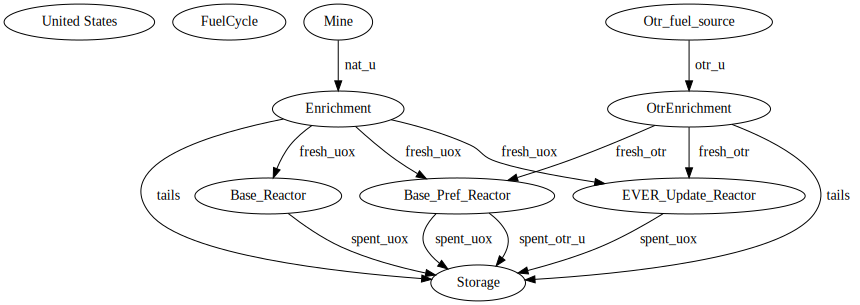

In [5]:
graphs.flow_graph(evaler, label='com')

In [44]:
reactor_list = ['Base_Reactor', 'Base_Pref_Reactor', 'EVER_Update_Reactor']

In [45]:
time = evaler.eval('TimeList')
commission_df = evaler.eval('BuildSeries')
decommission_df = evaler.eval('DecommissionSeries')

commission_df = commission_df.rename(index=str, columns={'EnterTime': 'Time'})
commission_df = tools.add_missing_time_step(commission_df, time)
commission_by_prototype = pd.pivot_table(
        commission_df,
        values='Count',
        index='Time',
        columns='Prototype',
        fill_value=0)

In [46]:
decommission_df = decommission_df.rename(index=str, columns={'ExitTime': 'Time'})
decommission_df = tools.add_missing_time_step(decommission_df, time)
decommission_by_prototype = pd.pivot_table(
        commission_df,
        values='Count',
        index='Time',
        columns='Prototype',
        fill_value=0)
negative_count = -decommission_df['Count']
decommission_df = decommission_df.drop('Count', axis=1)
decommission_df = pd.concat([decommission_df, negative_count], axis=1)
decommission_df.rename(columns={'ExitTime': 'Time'}, inplace=True)
decommission_by_prototype = decommission_df.pivot(index='Time', columns='Prototype')['Count'].reset_index()
decommission_by_prototype = decommission_by_prototype.fillna(0)

In [47]:
deployment_by_prototype = commission_by_prototype.copy()

for reactor in reactor_list:
    dep_rc = decommission_by_prototype[reactor] + commission_by_prototype[reactor]
    deployment_by_prototype[reactor] = dep_rc

In [48]:
deployment_by_prototype['Reactor_total'] = 0

if len(reactor_list)>1:
    for reactor in reactor_list:
        deployment_by_prototype['Reactor_total'] += deployment_by_prototype[reactor].cumsum()
else:
    deployment_by_prototype['Reactor_total'] = deployment_by_prototype[reactor_list[0]].cumsum()

Text(0, 0.5, 'Reactors [#]')

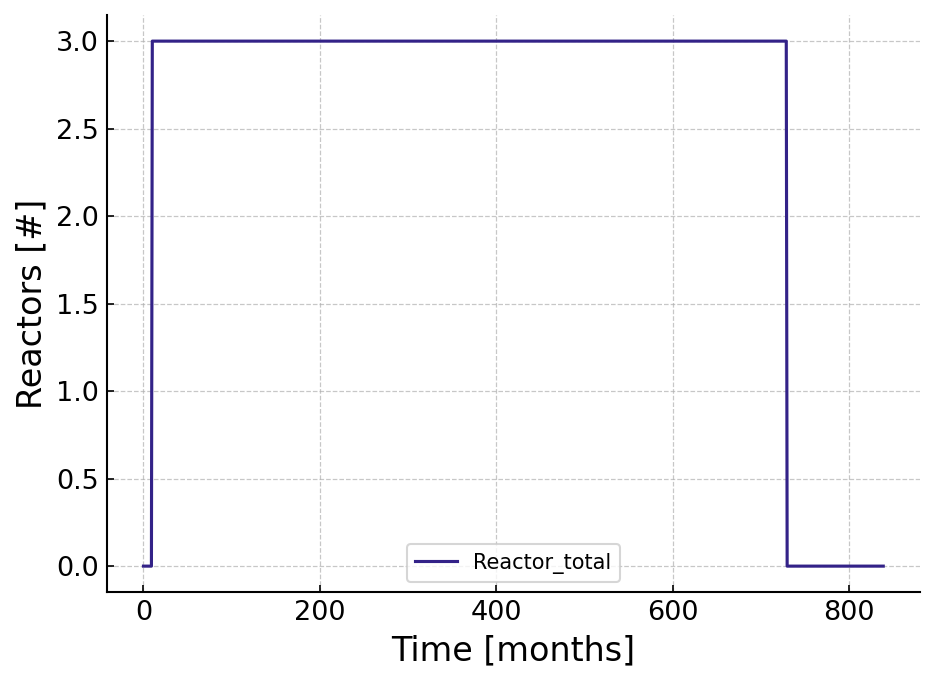

In [54]:
deployment_by_prototype[['Base_Pref_Reactor','Base_Reactor','EVER_Update_Reactor','Reactor_total']].plot(y='Reactor_total',use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Reactors [#]')

In [12]:
repository_waste = timeseries.transactions(evaler=evaler, receivers=['Storage'])

Text(0, 0.5, 'Mass of waste [kg]')

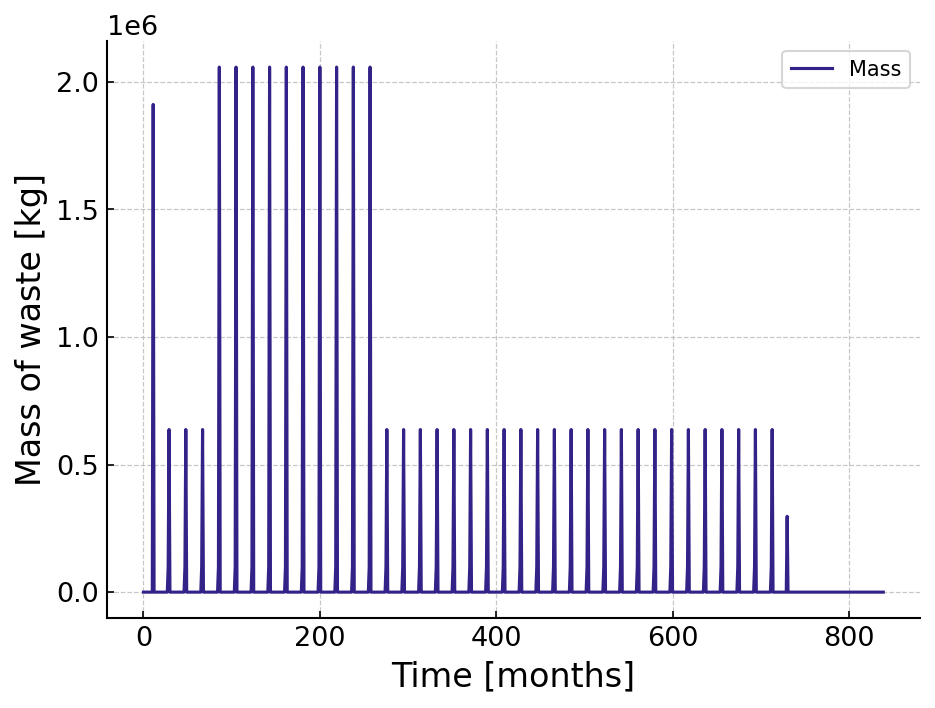

In [13]:
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

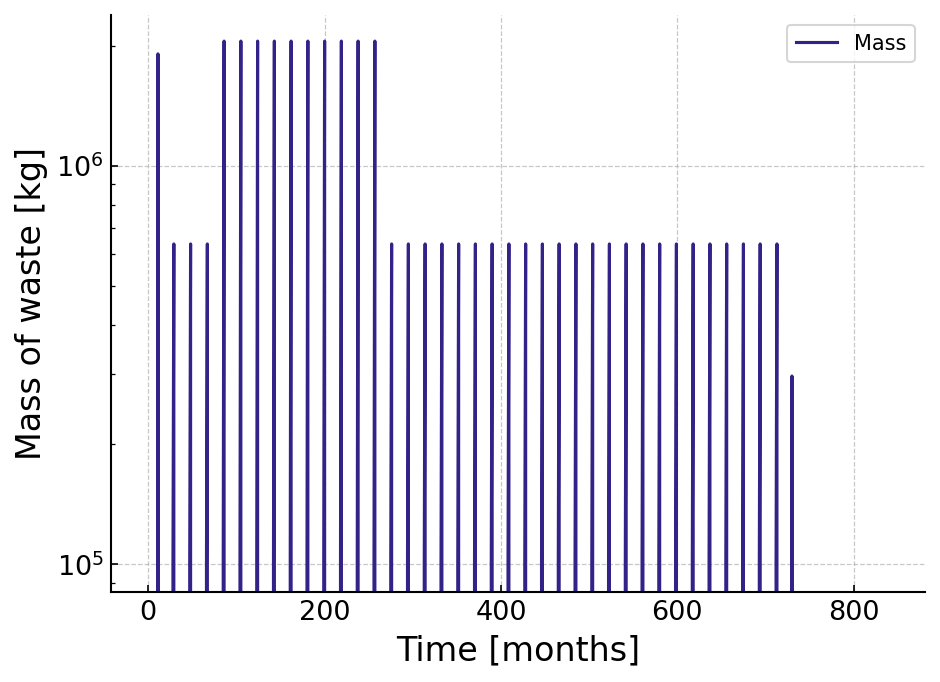

In [14]:
repository_waste.plot(x='Time', logy=True)
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

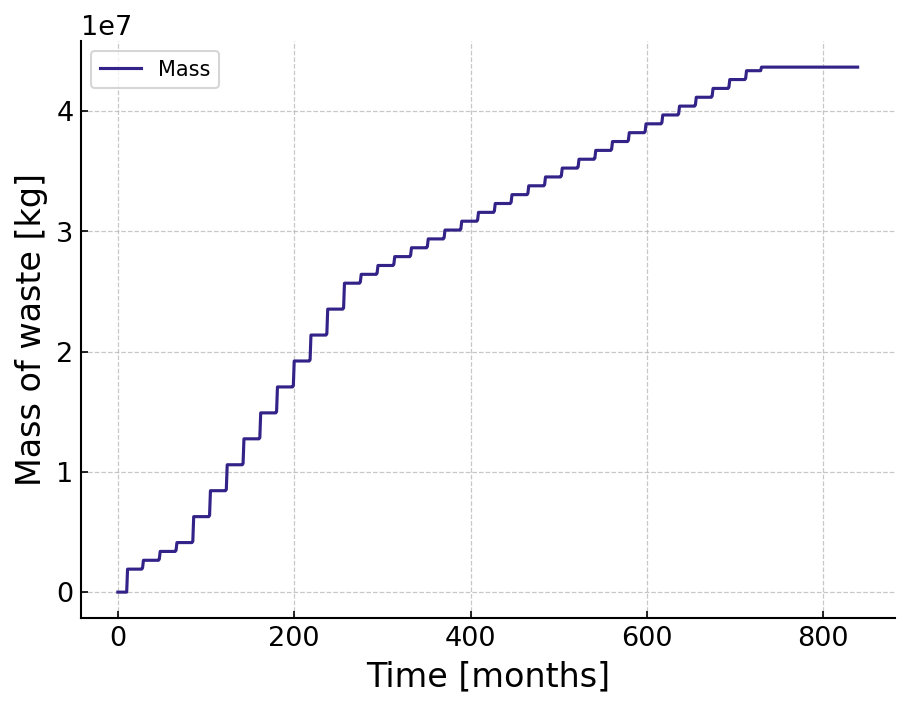

In [15]:
repository_waste['Mass'] = repository_waste['Mass'].cumsum()
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

In [16]:
reactor_input = timeseries.transactions(evaler=evaler, receivers=reactor_list)

In [17]:
transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
transactions = transactions.rename(columns={'TimeCreated':'Time'})

transactions['spent_uox_total'] = transactions.loc[transactions['Commodity'] == 'spent_uox']['Quantity'].cumsum()
transactions['fresh_uox_total'] = transactions.loc[transactions['Commodity'] == 'fresh_uox']['Quantity'].cumsum()

transactions['spent_otr_u_total'] = transactions.loc[transactions['Commodity'] == 'spent_otr_u']['Quantity'].cumsum()
transactions['otr_u_total'] = transactions.loc[transactions['Commodity'] == 'otr_u']['Quantity'].cumsum()

transactions.ffill(inplace=True)
transactions['total_fuel'] = transactions['spent_uox_total'] + transactions['spent_otr_u_total']

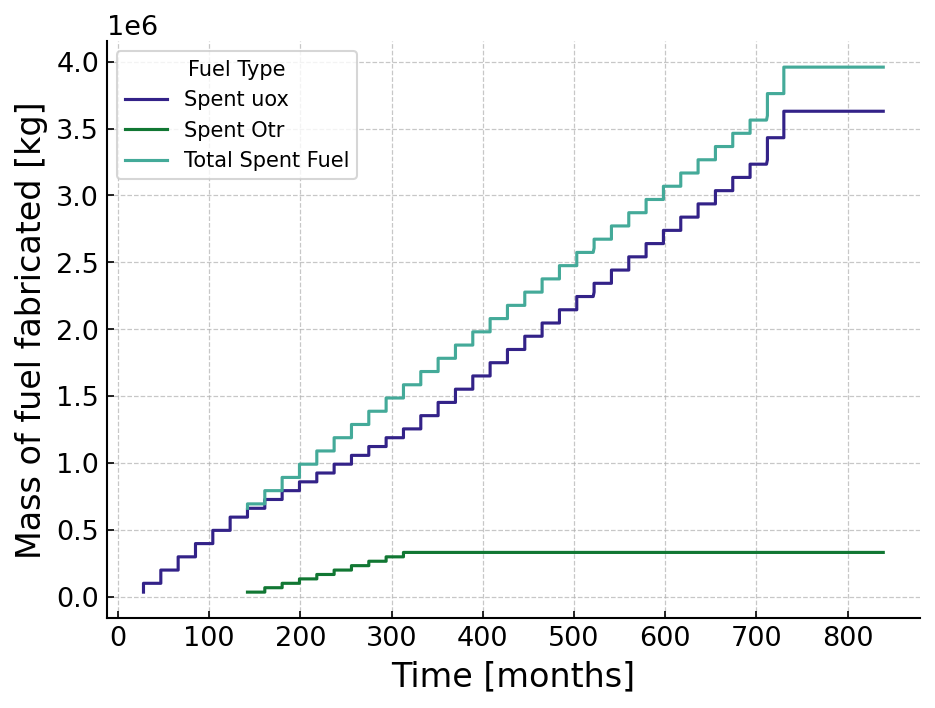

In [18]:
# Plotting cumulative fuel sent to reactors at each time step
transactions[['Time', 'spent_uox_total', 'spent_otr_u_total', 'total_fuel']].plot(x = 'Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of fuel fabricated [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text('Spent uox')
legend.get_texts()[1].set_text('Spent Otr')
legend.get_texts()[2].set_text('Total Spent Fuel')
legend.set_title('Fuel Type')

In [18]:
U235_mass = timeseries.transactions(evaler=evaler, receivers=['Base_Reactor', 'fresh_uox'], nucs=['92235'])
U235_mass['Mass'] = U235_mass['Mass'].cumsum()
U235_mass.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of U235 [kg]')

ImportError: pyne could not be imported: Unable to format nuclide !

# Sqlite Analysis
In this section, I will use basic sqlite to generate plots of the remaining data.

In [19]:
conn = sqlite3.connect('ever_update_test_out.sqlite')

In [20]:
cursor = conn.cursor()

In [21]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
columns = cursor.fetchall()

In [22]:
cursor.execute("SELECT * FROM Transactions")
reactinfo_rows = cursor.fetchall()

for row in reactinfo_rows:
    print(row)

(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 0, 27, 30, 15, 'otr_u', 0)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 1, 26, 28, 17, 'nat_u', 0)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 2, 27, 30, 32, 'otr_u', 1)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 3, 26, 28, 34, 'nat_u', 1)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 4, 27, 30, 49, 'otr_u', 2)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 5, 26, 28, 51, 'nat_u', 2)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 6, 27, 30, 66, 'otr_u', 3)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 7, 26, 28, 68, 'nat_u', 3)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 8, 27, 30, 83, 'otr_u', 4)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 9, 26, 28, 85, 'nat_u', 4)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 10, 27, 30, 100, 'otr_u', 5)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 11, 26, 28, 102, 'nat_u', 5)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 12, 27, 30, 117, 'otr_

In [23]:
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

for row in info_rows:
    print(row)

# define variables for the start and end of the simulation
start_year = info_rows[0][2]
start_month= info_rows[0][3]
end_month = info_rows[0][4]

(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', '', 2020, 1, 840, 20160212, 10000, b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'init', -1, '1.6.0', '1.6', '3.45.3', '1.14.3-', '1_85', '2.12.7', '-1')


In [24]:
# now we can add the rest of the dates from the simulation info
dates = pd.date_range(start=f'{start_year}-{start_month}-01', periods=end_month, freq='ME')

In [25]:
cursor.execute("SELECT * FROM DecomSchedule")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 33, 730, 730)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 34, 730, 730)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 35, 730, 730)


In [26]:
cursor.execute("SELECT * FROM BuildSchedule")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 25, 'Base_Reactor', 0, 10)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 25, 'Base_Pref_Reactor', 0, 10)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 25, 'EVER_Update_Reactor', 0, 10)


## Energy Production

In [27]:
# we will pull the decom schedule to see the ids and decomission date, to id the reactor
cursor.execute("SELECT * FROM DecomSchedule")
decom_rows = cursor.fetchall()

for row in decom_rows:
    print(row)

(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 33, 730, 730)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 34, 730, 730)
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 35, 730, 730)


In [28]:
# now we will pull the supplied power to get the amount of power from each reactor at every time step
cursor.execute("SELECT * FROM TimeSeriessupplyPOWER")
supply_rows = cursor.fetchall()

#for row in supply_rows:
#    print(row)

In [29]:
# create an empty dictionary that mirrors the format of the powersupply table
energy_supply = {
    'id':[],
    'time':[],
    'energy':[]
}

# now we will pull the power at each time step for each reactor
for row in range(len(supply_rows)):
    energy_supply['id'].append(str(supply_rows[row][1]))
    energy_supply['time'].append(supply_rows[row][2])
    energy_supply['energy'].append(supply_rows[row][3])

In [30]:
# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
energy_supply_df = pd.DataFrame.from_dict(energy_supply)

In [31]:
# we will turn the ids into columns of energy and make the index time
switch_energy_supply = energy_supply_df.pivot_table(index='time', columns='id', values='energy', fill_value=0)

# now we will add a total_energy column
switch_energy_supply['total_energy'] = switch_energy_supply.iloc[:,0:].sum(axis=1)

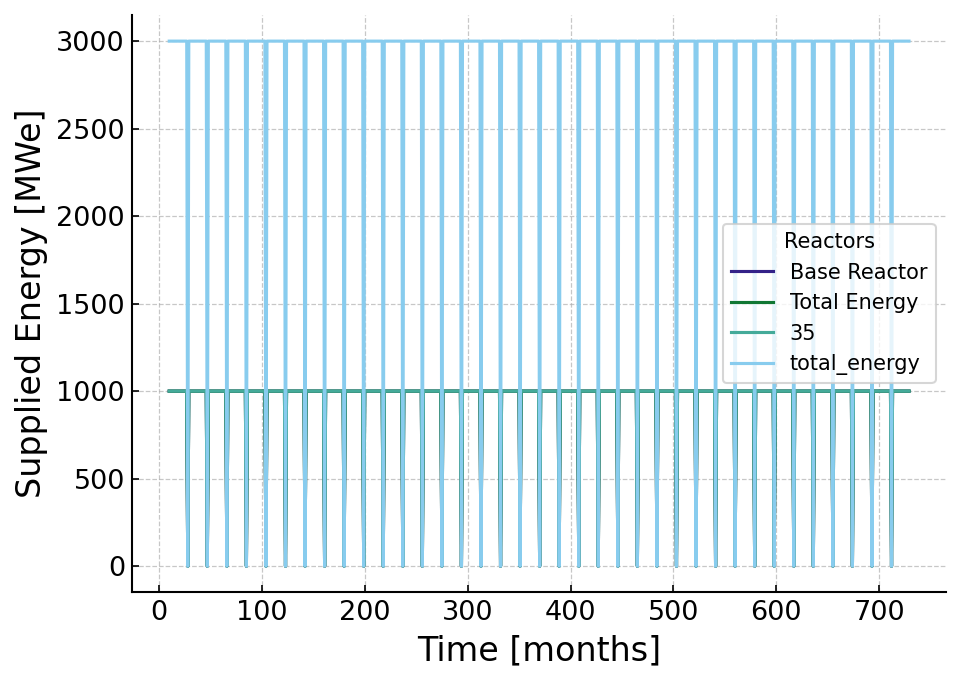

In [33]:
switch_energy_supply[['33','34','35','total_energy']].plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

In [34]:
simulation_energy_supply = pd.DataFrame(index=range(start_month,end_month), columns=switch_energy_supply.columns)
simulation_energy_supply = simulation_energy_supply.fillna(0)

for column in switch_energy_supply.columns:
    for time in range(min(switch_energy_supply.index), max(switch_energy_supply.index)):
        simulation_energy_supply.loc[time, column] = switch_energy_supply.loc[time, column]

/tmp/ipykernel_9397/2997257727.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  simulation_energy_supply = simulation_energy_supply.fillna(0)


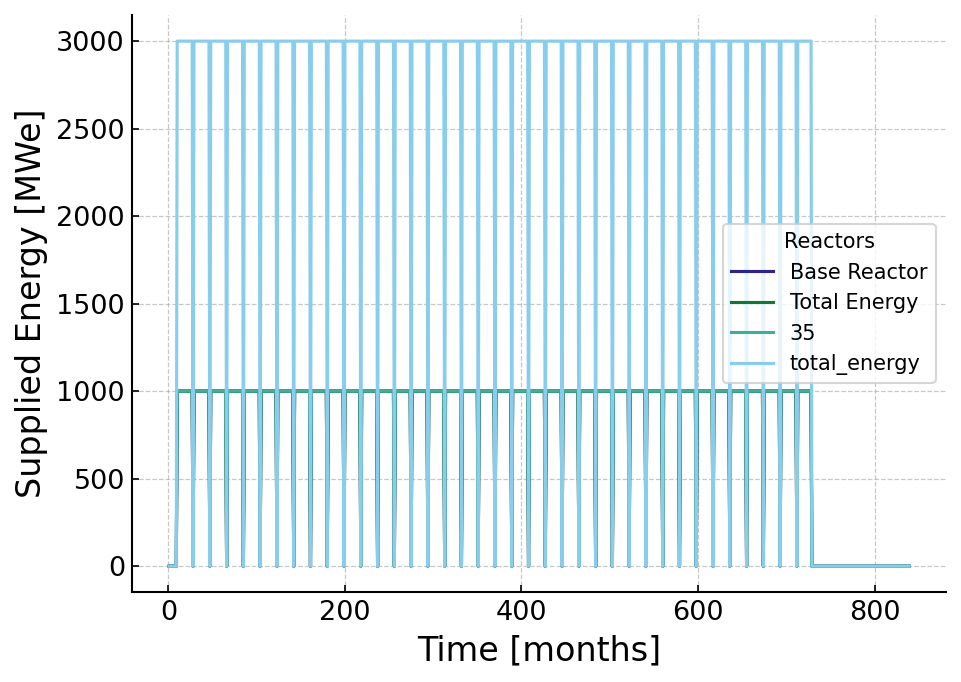

In [35]:
simulation_energy_supply.plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

## SWU

In [36]:
cursor.execute("SELECT * FROM TimeSeriesEnrichmentSWU")
swu_rows = cursor.fetchall()


for row in swu_rows:
   print(row)

(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 28, 0, 4.67507974280434e-310, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 29, 0, 0.0, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 30, 0, 0.0, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 31, 0, 0.0, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 28, 1, 4.67507974280434e-310, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 29, 1, 0.0, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 30, 1, 0.0, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 31, 1, 0.0, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 28, 2, 4.67507974280434e-310, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 29, 2, 0.0, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 30, 2, 0.0, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 31, 2, 0.0, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 28, 3, 4.67507974280434e-310, '')
(b'\x86\x17\xb0^\x86cA\x08\x91\xdd\x15?\xaett\\', 29, 3, 0.0, '')
(b'\

In [37]:
# create an empty dictionary that mirrors the format of the TimeSeriesEnrichmentSWU table
swu_supply = {
    'id':[],
    'Time':[],
    'SWU':[]
}

# now we will pull the swu at each time step for each facility
for row in range(len(swu_rows)):
    swu_supply['id'].append(str(swu_rows[row][1]))
    swu_supply['Time'].append(swu_rows[row][2])
    swu_supply['SWU'].append(swu_rows[row][3])

# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
swu_supply_df = pd.DataFrame.from_dict(swu_supply)

In [38]:
# we will turn the ids into columns of energy and make the index time
switch_swu_supply = swu_supply_df.pivot_table(index='Time', columns='id', values='SWU', fill_value=0)

# now we will add a total_energy column
switch_swu_supply['total_swu'] = switch_swu_supply.iloc[:,0:].sum(axis=1)

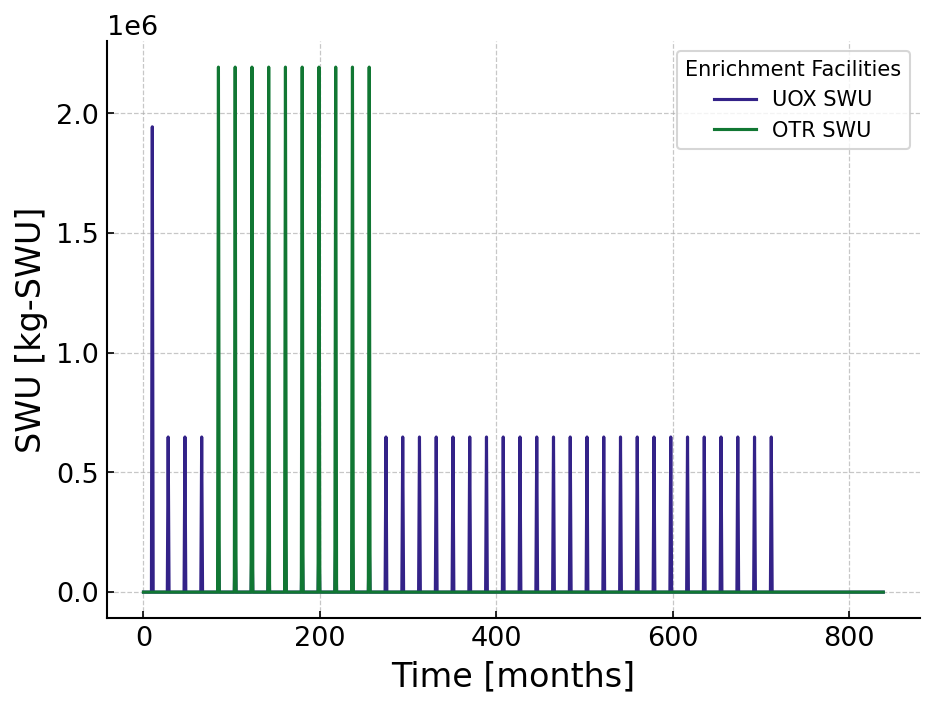

In [39]:
switch_swu_supply[['28', '30']].plot()
plt.xlabel('Time [months]')
plt.ylabel('SWU [kg-SWU]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('UOX SWU')
legend.get_texts()[1].set_text('OTR SWU')
# legend.get_texts()[2].set_text('Total SWU')
legend.set_title('Enrichment Facilities')